# Vectorizing t-tests and F-tests for unequal variances

When doing exploratory data analysis ([EDA](https://en.wikipedia.org/wiki/Exploratory_data_analysis)), rapid statistical testing provides a useful benchmark to assess the degree of signal in your data. Applied statisticians need to be careful not to over-interpret the results of EDA since the p-values generated during this phase are not mathematically sound. Since there are effectively infinite ways to analyze data to generate hypotheses for subsequent research, speed and flexibility are often desirable quantities. I recently encountered the problem of needing to assess thousands of AUROC statistics (discussed in the past [here](http://www.erikdrysdale.com/auc_CI/) and [here](http://www.erikdrysdale.com/auc_max/)), and found the bootstrapping procedure to be too slow for assessing significance. Instead I wanted to appeal to the asymptotic normality of the AUROC statistic (which is an instance of the [Mann-Whitney U-test](https://en.wikipedia.org/wiki/Mann–Whitney_U_test)) to perform rapid inference. There were two bottlenecks to carrying this out:

1. Needing to rely on only the moments of the data (mean, variance, and sample size)
2. Needing to account for unequal variances
3. Wanting to have a vectorized function

In the rest of the post, I'll provide some simple functions in `python` that will vectorize the [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) and the [F-test](https://en.wikipedia.org/wiki/F-test) for the multiple comparisons problem. Each of these functions will rely on only the first two moments of the data distribution. This helps to reduce the memory overhead that other functions would have by allowing these simple statistics to be pre-computed with the incredibly fast methods that are already part of `pandas` and `numpy` classes. The functions will also be able to account for unequal variances, which to best of my knowledge, is not available in existing `python` packages for the F-test.

## (1) Student's t-test for equal means

Suppose there are two normally distributed samples: $x = (x_1, \dots, x_n) \sim N(\mu_x, \sigma^2_x)$ and $y=(y_1,\dots,y_m)\sim N(\mu_y,\sigma^2_y)$, and we would like to test the null hypothesis that $H_0: \mu_x = \mu_y$. If the variances of the distributions were known in practice than the average difference of the two means would have a normal distribution,

$$
\begin{align*}
\frac{\bar{x} - \bar{y}}{\sqrt{\sigma^2_x/n + \sigma^2_y/m}} \sim N(0,1) \hspace{2mm} | \hspace{2mm} H_0 \text{ is true}
\end{align*}
$$

So that a test statistic with a known distribution could be easily constructed. However, since the variance of the two distributions needs to be estimated in practice, the statistic seen above would actually be the ratio of a normal to  chi-squared distribution, in other words a [Student's_t-distribution](https://en.wikipedia.org/wiki/Student's_t-distribution):

$$
\begin{align}
d &= \frac{\bar{x} - \bar{y}}{\sqrt{\hat\sigma^2_x/n + \hat\sigma^2_y/m}} \label{eq:dstat} \\
d &\sim t(\nu).
\end{align}
$$

When the variances are not equivalent, some modifications need to be made to the degrees of freedom parameter ($\nu$), using now classic derivations from [Welch](https://www.jstor.org/stable/2332510?seq=1) in 1947:

$$
\begin{align*}
\nu &= \begin{cases} 
n + m - 2 & \text{ if } \sigma^2_x = \sigma^2_y \\
\frac{(\hat\sigma^2_x/n + \hat\sigma^2_y/m)^2}{(\hat\sigma^2_x/n)^2/(x-1)+(\hat\sigma^2_y/m)^2/(m-1)} & \text{ if } \sigma^2_x \neq \sigma^2_y
\end{cases}.
\end{align*}
$$

 Because the test statistic $d$ is only a function of the first two moments,

$$
\begin{align*}
d = f(\bar x, \bar y, \hat\sigma^2_x, \hat\sigma^2_y, n, m)
\end{align*}
$$

We can easily write a function that takes these sufficient statistics from the data and save them for later testing. The code block below will provide the first function `tdist_2dist` to carry out the testing and return the test statistic and associated p-values from a two-sided hypothesis test.


In [1]:
# Import modules needed to reproduce results
import os
import plotnine
from plotnine import *
import pandas as pd
from scipy import stats
import numpy as np
from statsmodels.stats.proportion import proportion_confint as prop_CI

def tdist_2dist(mu1, mu2, se1, se2, n1, n2, var_eq=False):
    var1, var2 = se1**2, se2**2
    num = mu1 - mu2
    if var_eq:
        nu = n1 + n2 - 2
        sp2 = ((n1-1)*var1 + (n2-1)*var2) / nu
        den = np.sqrt(sp2*(1/n1 + 1/n2))
    else:
        nu = (var1/n1 + var2/n2)**2 / ( (var1/n1)**2/(n1-1) + (var2/n2)**2/(n2-1) )
        den = np.sqrt(var1/n1 + var2/n2)
    dist_null = stats.t(df=nu)
    tstat = num / den
    pvals = 2*np.minimum(dist_null.sf(tstat), dist_null.cdf(tstat))
    return tstat, pvals

# Useful short wrappers for making row or columns vectors
def rvec(x):
    return np.atleast_2d(x)

def cvec(x):
    return rvec(x).T

As a rule, I always conduct statistical simulations to make sure the functions I have written actually perform the way I expect them to when the null is known. If you can't get your method to work on a data generating procedure of your choosing, it should not leave the statistical laboratory! In the simulations below, $\mu_y = 0$, and $\mu_x$ will vary from zero to 0.2. At the same time, we will also experiment with weather $\sigma_y = \sigma_x$. To further ensure the approach works, we'll vary the $n$ and $m$ that occurs for each of the `nsim`=100K experiments from a random integer between 25 and 75. You'll notice that in order to avoid an inner loop and rely of pure `numpy` vectorization, we'll generate a data matrix of dimension 75 x 100000, but then set as missing the rows above the randomly generated sample count. The `np.nanmean` and `np.nanstd` functions need to be used because of this.

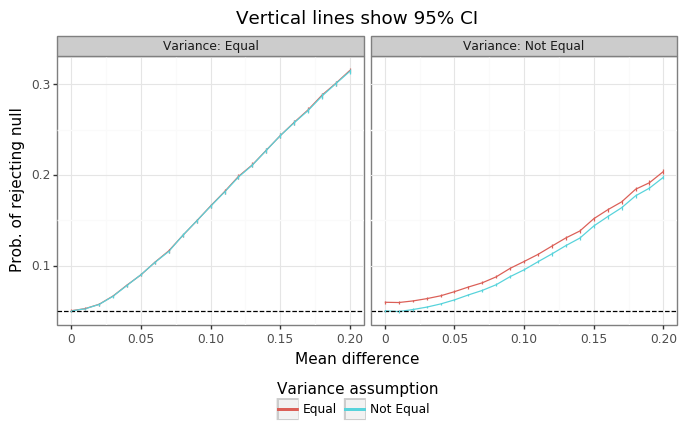

<ggplot: (8773139106021)>

In [2]:
nsim = 100000
nlow, nhigh = 25, 75
alpha = 0.05
n1, n2 = np.random.randint(nlow, nhigh+1, nsim), np.random.randint(nlow, nhigh+1, nsim)
se1, se2 = np.exp(np.random.randn(nsim)), np.exp(np.random.randn(nsim))
mu_seq = np.arange(0,0.21,0.01)
tt_seq, method_seq = np.repeat(['eq','neq'],2), np.tile(['neq','eq'],2)
holder = []
np.random.seed(1234)
for mu in mu_seq:
    x1 = mu + se1*np.random.randn(nhigh, nsim)
    x2a = se1 * np.random.randn(nhigh, nsim)
    x2b = se2 * np.random.randn(nhigh, nsim)
    idx = np.tile(np.arange(nhigh),[nsim,1]).T
    idx1, idx2 = idx < rvec(n1), idx < rvec(n2)
    x1, x2a, x2b = np.where(idx1, x1, np.nan), np.where(idx2, x2a, np.nan), np.where(idx2, x2b, np.nan)
    mu_hat1, mu_hat2a, mu_hat2b  = np.nanmean(x1, 0), np.nanmean(x2a, 0), np.nanmean(x2b, 0)
    se_hat1, se_hat2a, se_hat2b = np.nanstd(x1, 0, ddof=1), np.nanstd(x2a, 0, ddof=1), np.nanstd(x2b, 0, ddof=1)
    tstat_neq_a, pval_neq_a = tdist_2dist(mu_hat1, mu_hat2a, se_hat1, se_hat2a, n1, n2, False)
    tstat_eq_a, pval_eq_a = tdist_2dist(mu_hat1, mu_hat2a,  se_hat1, se_hat2a, n1, n2, True)
    tstat_neq_b, pval_neq_b = tdist_2dist(mu_hat1, mu_hat2b, se_hat1, se_hat2b, n1, n2, False)
    tstat_eq_b, pval_eq_b = tdist_2dist(mu_hat1, mu_hat2b, se_hat1, se_hat2b, n1, n2, True)
    power_neq_a, power_eq_a = np.mean(pval_neq_a < alpha), np.mean(pval_eq_a < alpha)
    power_neq_b, power_eq_b = np.mean(pval_neq_b < alpha), np.mean(pval_eq_b < alpha)
    power_seq = np.array([power_neq_a, power_eq_a, power_neq_b, power_eq_b])
    holder.append(pd.DataFrame({'mu':mu,'tt':tt_seq,'method':method_seq, 'power':power_seq}))
# Power comparison
di_method = {'eq':'Equal','neq':'Not Equal'}
res_power = pd.concat(holder).assign(nsim=nsim)
res_power[['tt','method']] = res_power[['tt','method']].apply(lambda x: x.map(di_method))
res_power = res_power.rename(columns={'tt':'Variance'}).assign(nreject=lambda x: (x.power*x.nsim).astype(int))
res_power = pd.concat([res_power.drop(columns=['nsim','nreject']),
            pd.concat(prop_CI(count=res_power.nreject,nobs=nsim,method='beta'),1)],1)
res_power.rename(columns={0:'lb',1:'ub'}, inplace=True)

plotnine.options.figure_size = (8, 3.5)
gg_power_ttest = (ggplot(res_power,aes(x='mu',y='power',color='method')) +
                  theme_bw()  + geom_line() +
                  geom_hline(yintercept=0.05,linetype='--') +
                  scale_color_discrete(name='Variance assumption') +
                  geom_linerange(aes(ymin='lb',ymax='ub')) +
                  ggtitle('Vertical lines show 95% CI') +
                  labs(y='Prob. of rejecting null',x='Mean difference') +
                  facet_wrap('~Variance',labeller=label_both) +
                  theme(legend_position=(0.5,-0.1),legend_direction='horizontal'))
gg_power_ttest

Figure 1 above shows that the `tdist_2dist` fuctino is working as expected. When the variances of $x$ and $y$ are equivalent, there is no difference in performance between approaches. When the mean difference is zero, the probability of rejecting the null is exactly equivalent to the level of the test: $\alpha=0.05$. However, when the variances differ, using the degrees of freedom calculation assuming they are equal leads to an inflated type-I error rate. Whereas using the adjustment from [Welch's t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test) gets to the right nominal level.

## (2) Checking power calculations

In addition to validating that your function's test-statistic has the right nominal coverage, it is useful to ensure you can accurately predict the power of the test for different values of the alternative hypothesis. For some test statistics, this is not possible to do analytically, since the distribution of the test statistic under the alternative may not be known. However, for the student-t distribution, a difference in means amounts to a [Noncentral_t-distribution](https://en.wikipedia.org/wiki/Noncentral_t-distribution).

$$
\begin{align*}
T &= \frac{Z + c}{\sqrt{V/\nu}} \\ 
T &\sim \text{nct}(\nu,c) \\
Z&\sim N(0,1), \hspace{3mm} V\sim \chi^2(\nu), \hspace{3mm} \mu \neq 0
\end{align*}
$$

It's easy to see that we can modify $d$ from \eqref{eq:dstat} to match the noncentral t-distribution:

$$
\begin{align*}
d + \underbrace{\frac{\mu_x - \mu_y}{\sqrt{\sigma^2_x/n + \sigma^2_y/m}}}_{c}.
\end{align*}
$$

The simulations below will fix $n=25$, $m=75$, and unit variances when $\sigma_x=\sigma_y$ and $\sigma_y=2$ otherwise.

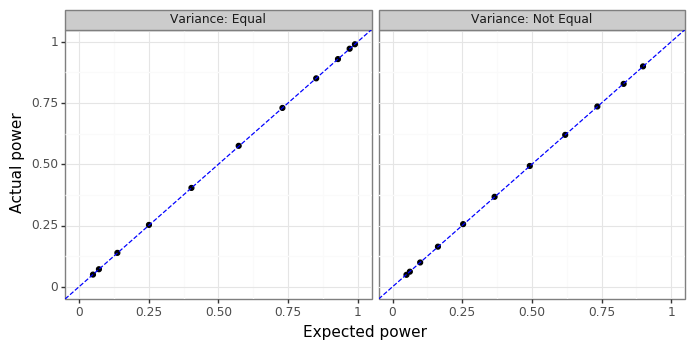

<ggplot: (8773135210013)>

In [3]:
nsim = 100000
alpha = 0.05
n1, n2 = 25, 75
se1 = 1
se2a, se2b = se1, se1 + 1
var1, var2a, var2b = se1**2, se2a**2, se2b**2
# ddof under different assumptions
nu_a = n1 + n2 - 2
nu_b = (var1/n1 + var2b/n2)**2 / ( (var1/n1)**2/(n1-1) + (var2b/n2)**2/(n2-1) )
mu_seq = np.round(np.arange(0, 1.1, 0.1),2)

# Pre-calculate power
crit_ub_a, crit_lb_a = stats.t(df=nu_a).ppf(1-alpha/2), stats.t(df=nu_a).ppf(alpha/2)
crit_ub_b, crit_lb_b = stats.t(df=nu_b).ppf(1-alpha/2), stats.t(df=nu_b).ppf(alpha/2)
lam_a = np.array([mu/np.sqrt(var1*(1/n1 + 1/n2)) for mu in mu_seq])
lam_b = np.array([mu/np.sqrt((var1/n1 + var2b/n2)) for mu in mu_seq])
dist_alt_a, dist_alt_b = stats.nct(df=nu_a, nc=lam_a), stats.nct(df=nu_b, nc=lam_b)
power_a = (1-dist_alt_a.cdf(crit_ub_a)) + dist_alt_a.cdf(crit_lb_a)
power_b = (1-dist_alt_b.cdf(crit_ub_b)) + dist_alt_b.cdf(crit_lb_b)
dat_theory = pd.concat([pd.DataFrame({'mu':mu_seq,'theory':power_a,'method':'eq'}),
                        pd.DataFrame({'mu':mu_seq,'theory':power_b,'method':'neq'})])

# Run simulations to confirm
np.random.seed(1234)
holder = []
for mu in mu_seq:
    x1 = mu + se1 * np.random.randn(n1, nsim)
    x2a = se2a * np.random.randn(n2, nsim)
    x2b = se2b * np.random.randn(n2, nsim)
    mu_hat1, mu_hat2a, mu_hat2b  = x1.mean(0), x2a.mean(0), x2b.mean(0)
    # print(mu_hat1.mean());print(mu_hat2a.mean());print(mu_hat2a.mean())
    se_hat1, se_hat2a, se_hat2b = x1.std(0,ddof=1), x2a.std(0, ddof=1), x2b.std(0, ddof=1)
    # print(se_hat1.mean());print(se_hat2a.mean());print(se_hat2a.mean())
    stat_a, pval_a = tdist_2dist(mu_hat1, mu_hat2a, se_hat1, se_hat2a, n1, n2, var_eq=True)
    stat_b, pval_b = tdist_2dist(mu_hat1, mu_hat2b, se_hat1, se_hat2b, n1, n2, var_eq=False)
    reject_a, reject_b = np.mean(pval_a < 0.05), np.mean(pval_b < 0.05)
    # print(reject_a);print(reject_b)
    holder.append(pd.DataFrame({'mu': mu,'method':['eq','neq'], 'power': [reject_a, reject_b]}))
res_theory = pd.concat(holder).merge(dat_theory).sort_values(['method','mu']).reset_index(None, True)
res_theory = res_theory.assign(nreject=lambda x: (x.power*nsim).astype(int))
res_theory = pd.concat([res_theory.drop(columns='nreject'),
                        pd.concat(prop_CI(count=res_theory.nreject,nobs=nsim,method='beta'),1)],1)
res_theory.rename(columns={0:'lb',1:'ub','method':'Variance'}, inplace=True)
res_theory = res_theory.assign(Variance=lambda x: x.Variance.map(di_method))

plotnine.options.figure_size = (8, 3.5)
gg_power_theory = (ggplot(res_theory,aes(x='theory',y='power')) +
                   theme_bw() + geom_point() +
                   geom_linerange(aes(ymin='lb',ymax='ub')) +
                   facet_wrap('~Variance', labeller=label_both) +
                   theme(legend_position=(0.5, -0.1), legend_direction='horizontal') +
                   labs(x='Expected power',y='Actual power') +
                   scale_y_continuous(limits=[0,1]) + scale_x_continuous(limits=[0,1]) +
                   geom_abline(slope=1,intercept=0,color='blue',linetype='--'))
gg_power_theory

Figure 2 shows that the power calculations line up exactly with the analytical expectations we have for both equal and unequal variances. Having thoroughly validated the type-I and type-II errors of this function we can now move onto testing whether the means from multiple normal distributions are equal. 

## (3) F-tests for equality of means

Suppose there are $K$ normal data vectors: $x_1=(x_{1,1},\dots,x_{1,n_1})$ to $x_k=(x_{k,1},\dots,x_{1,n_k})$, and we want to test the null hypothesis of $\mu_1 = \mu_2 = \dots = \mu_K$ against a null hypothesis that there is at least 1 of $K-1$ possible inequalities in the means, where $x_{ki} \sim N(\mu_k,\sigma^2_k)$. As before, the variances of each vector may or may not be equal. Under the null of equal variance, the squared different the global average and any one group mean will be chi-square. Similarly, the sum of the sample variances will also have a chi-square distribution. Hence, the F-test for equality of means is the ratio of the variation "between" versus "within" the groups,

$$
\begin{align*}
R &= \frac{\frac{1}{K-1}\sum_{k=1}^K n_k (\bar x_k - \bar x)^2 }{\frac{1}{N-K}\sum_{k=1}^K (n_k - 1)\hat\sigma^2_k}, \\
R &\sim F(K-1, N-K) \hspace{3mm} \text{ if } \sigma^2_k = \sigma^2 \hspace{3mm} \forall k \in \{1,\dots,K\}
\end{align*}
$$

Where $N = \sum_k n_k$. To account for heteroskedasticity in the data (i.e. non-equal variances), both the test and degrees of freedom need to be modified using an [approach](https://doi.org/10.2307/2332579) Welch proposed in 1951.

$$
\begin{align*}
R_W &= \frac{\frac{1}{K-1}\sum_{k=1}^K w_k (\bar x_k - \bar x_w)^2 }{1 + \frac{2}{3}((K-2)\nu)}, \\
w_k &= n_k / \hat\sigma^2_k \\
\bar x_w &= \frac{\sum_{k=1}^K w_k \bar x_k}{\sum_{k=1}^K w_k}\\
\nu &= \frac{3\cdot \sum_{k=1}^K \Bigg[ \frac{1}{n_k - 1} \Big( 1 - \frac{w_k}{\sum_{k=1}^K w_k} \Big)^2 \Bigg]^2}{K^2-1} \\
R_W &\sim F(K-1, 1/\nu) \hspace{3mm} \text{ if } \sigma^2_k \neq \sigma^2_{-k} \hspace{3mm} \text{for at least one }k
\end{align*}
$$

The `fdist_anova` function below carries an F-test for the equality of means using only the empirical means, standard deviations, and sample sizes for either variance assumption. In `R` this would be equivalent to using `aov` (for equal variances) or `oneway.test` for unequal variances. In `python`, it will replicate the `scipy.stats.f_oneway` function (for equal variances). I am unaware of a `python` function that does a Welch-adjustment (if you know please message me and I will update). As before, because the function only relies on the moments of the data, it can be fully vectorized to handle matrices of means, variances, and sample sizes. 

The simulation runs below test how well the two F-test approaches (homoskedasticity vs heteroskedasticity) do when the ground truth variances are either all equal or vary. To vary the "signal" of the data, I generate the $K$ different means from $(-\mu,\dots,0,\dots,\mu)$, what I call "mean dispersion" on the figure below (i.e. $\mu$).

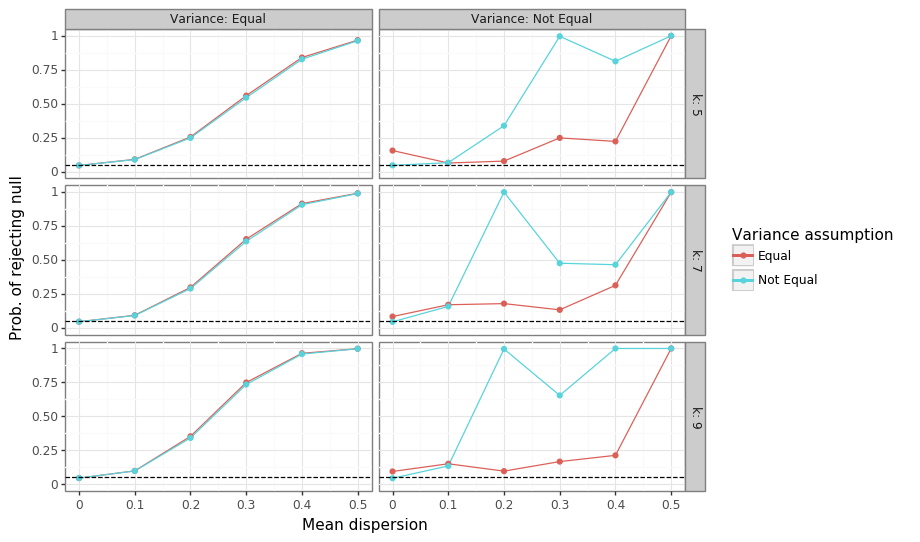

<ggplot: (8773133458573)>

In [5]:
def fdist_anova(mus, ses, ns, var_eq=False):
    lshape = len(mus.shape)
    assert lshape <= 2
    assert mus.shape == ses.shape
    if len(ns.shape) == 1:
        ns = cvec(ns.copy())
    else:
        assert ns.shape == mus.shape
    if lshape == 1:
        mus = cvec(mus.copy())
        ses = cvec(ses.copy())
    vars = ses ** 2  # variance
    n, k = ns.sum(0), len(ns)  # Total samples and groups
    df1, df2 = (k - 1), (n - k)
    if var_eq:  # classical anova
        xbar = np.atleast_2d(np.sum(mus * ns, 0) / n)
        vb = np.sum(ns*(xbar - mus)**2,0) / df1  # numerator is variance between
        vw = np.sum((vars * (ns - 1)), 0) / df2  # den is variance within
        fstat = vb / vw
        pval = stats.f(dfn=df1,dfd=df2).sf(fstat)
    else:
        w = ns / vars
        xbar = np.sum(w * mus, 0) / np.sum(w,0)
        num = np.sum(w * (xbar - mus) ** 2,0) / df1
        v = 3*np.sum((1-w/w.sum(0))**2 / (ns-1),0) / (k**2 - 1)
        den = 1 + 2*((k-2)*v)/3
        fstat = num / den
        pval = stats.f(dfn=df1, dfd=1/v).sf(fstat)
    return fstat, pval

nlow, niter = 25, 5
nsim = 100000
alpha = 0.05
k_seq = [5, 7, 9]
disp_seq = np.round(np.arange(0, 0.51, 0.1),2)
dgp_seq = np.repeat(['eq', 'neq'], 2)
method_seq = np.tile(['eq', 'neq'], 2)

holder = []
np.random.seed(1)
for k in k_seq:
    n_seq = np.arange(nlow, nlow+k * niter, niter)
    n_seq = np.tile(n_seq, [nsim, 1]).T
    nhigh = np.max(n_seq)
    dim_3d = [1, 1, k]
    for disp in disp_seq:
        mu_k = np.linspace(-disp, disp, num=k)
        se_k1 = np.repeat(1,k).reshape(dim_3d)
        se_k2 = np.exp(np.random.randn(k)).reshape(dim_3d)
        X1 = mu_k + se_k1 * np.random.randn(nhigh,nsim,k)
        X2 = mu_k + se_k2 * np.random.randn(nhigh, nsim, k)
        idx = np.tile(np.arange(nhigh),[k,nsim,1]).T <= np.atleast_3d(n_seq).T
        X1, X2 = np.where(idx, X1, np.nan), np.where(idx, X2, np.nan)
        # Calculate means and variance : (k x nsim)
        mu_X1, mu_X2 = np.nanmean(X1, 0).T, np.nanmean(X2, 0).T
        se_X1, se_X2 = np.nanstd(X1, 0, ddof=1).T, np.nanstd(X2, 0, ddof=1).T
        assert n_seq.shape == mu_X1.shape == se_X1.shape
        # Calculate significance
        fstat_eq1, pval_eq1 = fdist_anova(mus=mu_X1, ses=se_X1, ns=n_seq, var_eq=True)
        fstat_neq1, pval_neq1 = fdist_anova(mus=mu_X1, ses=se_X1, ns=n_seq, var_eq=False)
        fstat_eq2, pval_eq2 = fdist_anova(mus=mu_X2, ses=se_X2, ns=n_seq, var_eq=True)
        fstat_neq2, pval_neq2 = fdist_anova(mus=mu_X2, ses=se_X2, ns=n_seq, var_eq=False)
        reject_eq1, reject_neq1 = np.mean(pval_eq1 < alpha), np.mean(pval_neq1 < alpha)
        reject_eq2, reject_neq2 = np.mean(pval_eq2 < alpha), np.mean(pval_neq2 < alpha)
        reject_seq = [reject_eq1, reject_neq1, reject_eq2, reject_neq2]
        tmp = pd.DataFrame({'k':k,'disp':disp,'dgp':dgp_seq,'method':method_seq,'reject':reject_seq})
        # print(tmp)
        holder.append(tmp)
res_f = pd.concat(holder).reset_index(None,True)
res_f[['dgp','method']] = res_f[['dgp','method']].apply(lambda x: x.map(di_method),0)
res_f.rename(columns={'dgp':'Variance'}, inplace=True)

plotnine.options.figure_size = (8, 6)
gg_fdist = (ggplot(res_f, aes(x='disp',y='reject',color='method.astype(str)')) +
            theme_bw() + geom_line() + geom_point() +
            facet_grid('k~Variance',labeller=label_both) +
            labs(x='Mean dispersion',y='Prob. of rejecting null') +
            geom_hline(yintercept=0.05,linetype='--') +
            scale_y_continuous(limits=[0,1]) +
            scale_color_discrete(name='Variance assumption'))
gg_fdist

The simulations in Figure 3 show a similar finding to the that of t-test: when the ground truth variances are equal, there is almost no differences between the tests, and an expected 5% false positive rate occurs when the means are equal. However, for the unequal variance situation, the assumption of homoskedasticity leads to an inflated type-I error rate (as was the case for the t-test), but also lower power when the null is false (which was not the case for the t-test). The conclusion is the same for both however, it is better to use the Welch adjustment in both cases. The one surprising finding is that the power of the test is not monotonically increasing in the heteroskedastic case. I am not completely sure why this is the case. One theory could be that since a higher mean dispersion leads to a higher variance of $\bar{x}_w$, the ratio of the degrees of freedom may be more stable for lower values of $\mu$, leading to a more consistent rejection rate.

## (4) Quick sanity checks

After confirming the frequentist properties of your test statistic, it is usually worthwhile checking the results of any custom function to similar functions from other libraries. 

## (5) Application to AUROC inference